# EECS 731 Final Project - Clothing One
## Classification

In [289]:
import pandas as pd
import pickle
import warnings
warnings.filterwarnings('ignore')

In [290]:
reviews = pickle.load(open("../Data/reviews.pkl", "rb" ))
rented_for_encoding = pickle.load(open("../Data/rented_for_encoding.pkl", "rb"))
body_type_encoding = pickle.load(open("../Data/body_type_encoding.pkl", "rb"))
category_encoding = pickle.load(open("../Data/category_encoding.pkl", "rb"))

### Display the Dataframes from the Pickles

In [291]:
reviews.head()

,age,body_type,category,fit,height,item_id,rating,rented_for,review_date,size,user_id,weight,bust_volume,bust_height
0,28,3,44,fit,68.0,2260466,10,6,2016-04-20,14,420272,137,590,4
1,36,6,20,fit,66.0,153475,10,3,2013-06-18,12,273551,132,390,2
2,34,4,16,fit,65.0,126335,8,2,2014-02-12,8,909926,135,480,3
3,27,1,20,fit,69.0,616682,10,7,2016-09-26,12,151944,145,390,2
4,45,1,16,fit,68.0,364092,8,0,2016-04-30,8,734848,138,310,2


In [292]:
rented_for_encoding.head()

,encoding
labels,
date,0
everyday,1
formal affair,2
other,3
party,4


In [293]:
body_type_encoding.head()

,encoding
labels,
apple,0
athletic,1
full bust,2
hourglass,3
pear,4


In [294]:
category_encoding.head()

,encoding
labels,
ballgown,0
blazer,1
blouse,2
blouson,3
bomber,4


In [295]:
#Necessary imports
from sklearn.ensemble import RandomForestClassifier #Decision Tree Classifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split # can split data into test test & train set
from sklearn import metrics # Can calculate how accurrate our model is
from sklearn import preprocessing
from sklearn.neural_network import MLPClassifier

### Split the Dataset Into Training and Testing Data

In [296]:
# Remove fit, the target variable, and features that
# are only received after the item has been bought.
X = reviews.drop(['fit', 'rating', 'review_date'], axis=1)
Y = reviews['fit']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)
X_train.head()

,age,body_type,category,height,item_id,rented_for,size,user_id,weight,bust_volume,bust_height
84461,32,1,16,66.0,620288,4,8,699477,132,590,4
76724,30,6,20,64.0,125564,7,4,565624,115,310,2
52214,23,1,20,65.0,125564,2,12,903377,140,480,3
113062,23,2,45,61.0,963476,4,1,256614,120,590,6
85702,29,1,53,70.0,2007354,1,8,550942,135,480,3


### Classifier Models:
- Random Forest (10 estimators)
- Random Forest (100 estimators)
- Gradient Boosting
- Neural Network: Multilayer Perceptron

In [297]:
# # Create classifers
rf10 = RandomForestClassifier(n_estimators=10, n_jobs=-1)
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
gb = GradientBoostingClassifier(random_state=1, learning_rate=.1)
nn = MLPClassifier()

# Train Classifers
rf10 = rf10.fit(X_train, Y_train)
rf = rf.fit(X_train, Y_train)
gb = gb.fit(X_train, Y_train)
nn = nn.fit(X_train, Y_train)

#Predict the response for test dataset
rf10_y_pred = rf10.predict(X_test)
rf_y_pred = rf.predict(X_test)
gb_y_pred = gb.predict(X_test)
nn_y_pred = nn.predict(X_test)

print("Random Forest:")
print("10 estimators Training Accuracy:", metrics.accuracy_score(Y_train, rf10.predict(X_train)))
print("10 estimators Test Accuracy:",metrics.accuracy_score(Y_test, rf10_y_pred))
print("100 estimators Training Accuracy:", metrics.accuracy_score(Y_train, rf.predict(X_train)))
print("100 estimators Test Accuracy:",metrics.accuracy_score(Y_test, rf_y_pred))

print("\nGradient Boosting:")
print("Training Accuracy:", metrics.accuracy_score(Y_train, gb.predict(X_train)))
print("Test Accuracy:",metrics.accuracy_score(Y_test, gb_y_pred))

print("\nNeural Network:")
print("Training Accuracy:", metrics.accuracy_score(Y_train, nn.predict(X_train)))
print("Test Accuracy:",metrics.accuracy_score(Y_test, nn_y_pred))

What % of users rate the fit of the product as "fit" to see if either model gave us additional information

Fit   %: 0.7359766636380405
Small %: 0.1340474515135161
Large %: 0.12997588484844344


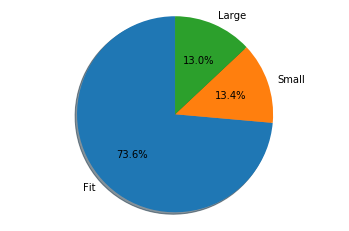

In [298]:
print("Fit   %:", ((reviews[reviews.fit == 'fit'].shape[0]) / (len(reviews.index))))
print("Small %:", ((reviews[reviews.fit == 'small'].shape[0]) / (len(reviews.index))))
print("Large %:", ((reviews[reviews.fit == 'large'].shape[0]) / (len(reviews.index))))

sizes = [reviews[reviews.fit == 'fit'].shape[0], reviews[reviews.fit == 'small'].shape[0], reviews[reviews.fit == 'large'].shape[0]]
labels = ["Fit", "Small", "Large"]
import matplotlib.pyplot as plt
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')
plt.show()

More information is gained simply by guessing "fit" on every item, so these models provide us no additional information.

In [299]:
# import numpy as np
rfImportances = pd.DataFrame(rf.feature_importances_, index = X_train.columns, columns =['importance']).sort_values('importance', ascending=False)
gbImportances = pd.DataFrame(gb.feature_importances_, index = X_train.columns, columns =['importance']).sort_values('importance', ascending=False)
rfImportances

In [300]:
# gbImportances

In [301]:
from sklearn.utils import resample
def resample_data(df):
    # Separate majority and minority classes
    df_majority = df[df.fit=='fit']
    df_minority_1 = df[df.fit=='small']
    df_minority_2 = df[df.fit=='large']

    size = df_majority.shape[0]
    
    # Upsample minority class
    df_minority_1_upsampled = resample(df_minority_1, 
                                     replace=True,     # sample with replacement
                                     n_samples=size,    # to match majority class
                                     random_state=123) # reproducible results
    
    df_minority_2_upsampled = resample(df_minority_2, 
                                     replace=True,     # sample with replacement
                                     n_samples=size,    # to match majority class
                                     random_state=123) # reproducible results
    # # Combine majority class with upsampled minority class
    df_upsampled = pd.concat([df_majority, df_minority_1_upsampled, df_minority_2_upsampled]).sample(frac=1)

    return df_upsampled

In [302]:
X_train['fit'] = Y_train.values
X_test['fit'] = Y_test.values

In [303]:
X_train_resampled = resample_data(X_train)
X_test_resampled = resample_data(X_test)

In [304]:
Y_train_resampled = X_train_resampled['fit']
Y_test_resampled = X_test_resampled['fit']
X_train_resampled = X_train_resampled.drop(['fit'],axis = 1)
X_test_resampled = X_test_resampled.drop(['fit'], axis = 1)

In [305]:
def fit_to_int(x):
    if x == 'fit':
        return 0
    elif x == 'large':
        return 1
    return -1
Y_train_resampled = Y_train_resampled.map(fit_to_int)
Y_test_resampled = Y_test_resampled.map(fit_to_int)

### Display the Resampled Data

In [306]:
X_train_resampled.head()

,age,body_type,category,height,item_id,rented_for,size,user_id,weight,bust_volume,bust_height
79227,26,4,16,66.0,1600223,7,39,925002,200,710,3
129767,26,1,16,66.0,607186,7,8,714383,143,480,3
86004,29,4,16,64.0,511441,7,1,387413,113,310,2
77189,37,1,46,65.0,862815,7,12,960413,130,590,5
52528,32,6,16,69.0,126335,7,4,619030,140,390,2


In [307]:
X_test_resampled.head()

,age,body_type,category,height,item_id,rented_for,size,user_id,weight,bust_volume,bust_height
143411,44,6,16,68.0,174799,0,16,895169,135,480,4
50497,32,5,45,63.0,963476,4,4,980829,115,390,2
138361,33,5,16,60.0,472922,2,1,864928,98,310,1
93648,52,5,16,62.0,652854,8,1,816183,105,390,2
15194,37,6,16,69.0,998947,4,12,696745,145,390,2


In [308]:
Y_train_resampled.head()

79227     0
129767    1
86004     0
77189     0
52528     1
Name: fit, dtype: int64

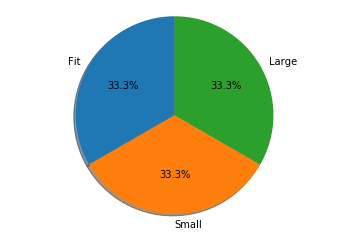

In [309]:
ytr = list(Y_train_resampled)
sizes = [len([x for x in ytr if x == 0]), len([x for x in ytr if x == -1]), len([x for x in ytr if x == 1])]
labels = ["Fit", "Small", "Large"]
import matplotlib.pyplot as plt
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')
plt.show()

In [310]:
Y_test_resampled.head()

143411    1
50497     1
138361    0
93648     1
15194     1
Name: fit, dtype: int64

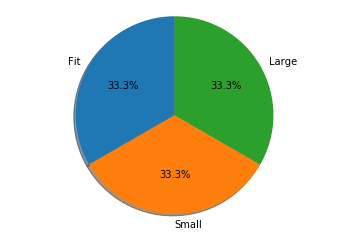

In [311]:
ytr = list(Y_test_resampled)
sizes = [len([x for x in ytr if x == 0]), len([x for x in ytr if x == -1]), len([x for x in ytr if x == 1])]
labels = ["Fit", "Small", "Large"]
import matplotlib.pyplot as plt
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')
plt.show()

### Classifier Models on Resampled Data:
- Random Forest (10 estimators)
- Random Forest (100 estimators)
- Gradient Boosting
- Neural Network: Multilayer Perceptron

In [312]:
# Create classifers
rf10 = RandomForestClassifier(n_estimators=10, n_jobs=-1)
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
gb = GradientBoostingClassifier()
nn = MLPClassifier()

# Train Classifers
rf10 = rf10.fit(X_train_resampled, Y_train_resampled)
rf = rf.fit(X_train_resampled, Y_train_resampled)
gb = gb.fit(X_train_resampled, Y_train_resampled)
nn = nn.fit(X_train_resampled, Y_train_resampled)

#Predict the response for test dataset
rf10_y_pred = rf10.predict(X_test_resampled)
rf_y_pred = rf.predict(X_test_resampled)
gb_y_pred = gb.predict(X_test_resampled)
nn_y_pred = nn.predict(X_test_resampled)

print("Random Forest:")
print("10 estimators Training Accuracy:", metrics.accuracy_score(Y_train_resampled, rf10.predict(X_train_resampled)))
print("10 estimators Test Accuracy:",metrics.accuracy_score(Y_test_resampled, rf10_y_pred))
print("100 estimators Training Accuracy:", metrics.accuracy_score(Y_train_resampled, rf.predict(X_train_resampled)))
print("100 estimators Test Accuracy:",metrics.accuracy_score(Y_test_resampled, rf_y_pred))

print("\nGradient Boosting:")
print("Training Accuracy:", metrics.accuracy_score(Y_train_resampled, gb.predict(X_train_resampled)))
print("Test Accuracy:",metrics.accuracy_score(Y_test_resampled, gb_y_pred))

print("\nNeural Network:")
print("Training Accuracy:", metrics.accuracy_score(Y_train_resampled, nn.predict(X_train_resampled)))
print("Test Accuracy:",metrics.accuracy_score(Y_test_resampled, nn_y_pred))

On the resample: Even thirds, 33% small, 33% fit, 33% large
Gradient Boosting here is 50% more accurate than random guessing

In [313]:
#Y_test_resampled.head()
a = pd.DataFrame(Y_test_resampled)
print(a.head())

print( (len(a[a['fit'] == 0])) / (len(a.index))  )

        fit
143411    1
50497     1
138361    0
93648     1
15194     1
0.3333333333333333


In [314]:
# import numpy as np

rfImportances = pd.DataFrame(rf.feature_importances_, index = X_train_resampled.columns, columns =['importance']).sort_values('importance', ascending=False)
gbImportances = pd.DataFrame(gb.feature_importances_, index = X_train_resampled.columns, columns =['importance']).sort_values('importance', ascending=False)
rfImportances

In [315]:
gbImportances

## Using Anomaly-Free Data

In [316]:
reviews = pickle.load(open("../Data/reviews_anomalies_removed.pkl", "rb" ))

In [317]:
# Remove fit, the target variable, and features that
# are only received after the item has been bought.
X = reviews.drop(['fit', 'rating', 'review_date'], axis=1)
Y = reviews['fit']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)
X_train.head()

,age,body_type,category,height,item_id,rented_for,size,user_id,weight,bust_volume,bust_height
129033,31,4,16,64.0,1746190,7,4,278562,130,310,2
61782,28,3,32,65.0,265806,7,8,356213,130,390,3
15590,58,4,20,67.0,132738,2,13,833182,133,310,1
111496,28,3,16,65.0,126335,4,12,193966,140,590,4
140918,27,4,16,65.0,148690,0,20,165402,160,590,3


### Classifier Models:
- Random Forest (10 estimators)
- Random Forest (100 estimators)
- Gradient Boosting
- Neural Network: Multilayer Perceptron

In [318]:
# # Create classifers
rf10 = RandomForestClassifier(n_estimators=10)
rf = RandomForestClassifier(n_estimators=100)
gb = GradientBoostingClassifier(random_state=1, learning_rate=.1)
nn = MLPClassifier()

# Train Classifers
rf10 = rf10.fit(X_train, Y_train)
rf = rf.fit(X_train, Y_train)
gb = gb.fit(X_train, Y_train)
nn = nn.fit(X_train, Y_train)

#Predict the response for test dataset
rf10_y_pred = rf10.predict(X_test)
rf_y_pred = rf.predict(X_test)
gb_y_pred = gb.predict(X_test)
nn_y_pred = nn.predict(X_test)

print("Random Forest:")
print("10 estimators Training Accuracy:", metrics.accuracy_score(Y_train, rf10.predict(X_train)))
print("10 estimators Test Accuracy:",metrics.accuracy_score(Y_test, rf10_y_pred))
print("100 estimators Training Accuracy:", metrics.accuracy_score(Y_train, rf.predict(X_train)))
print("100 estimators Test Accuracy:",metrics.accuracy_score(Y_test, rf_y_pred))

print("\nGradient Boosting:")
print("Training Accuracy:", metrics.accuracy_score(Y_train, gb.predict(X_train)))
print("Test Accuracy:",metrics.accuracy_score(Y_test, gb_y_pred))

print("\nNeural Network:")
print("Training Accuracy:", metrics.accuracy_score(Y_train, nn.predict(X_train)))
print("Test Accuracy:",metrics.accuracy_score(Y_test, nn_y_pred))

What % of users rate the fit of the product as "fit" to see if either model gave us additional information

Fit   %: 0.6149078100710365
Small %: 0.20996084141758004
Large %: 0.17513134851138354


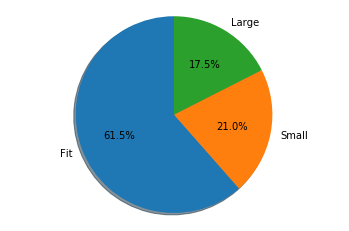

In [319]:
print("Fit   %:", ((reviews[reviews.fit == 'fit'].shape[0]) / (len(reviews.index))))
print("Small %:", ((reviews[reviews.fit == 'small'].shape[0]) / (len(reviews.index))))
print("Large %:", ((reviews[reviews.fit == 'large'].shape[0]) / (len(reviews.index))))

sizes = [reviews[reviews.fit == 'fit'].shape[0], reviews[reviews.fit == 'small'].shape[0], reviews[reviews.fit == 'large'].shape[0]]
labels = ["Fit", "Small", "Large"]
import matplotlib.pyplot as plt
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')
plt.show()

More information is gained simply by guessing "fit" on every item, so these models provide us no additional information.

In [320]:
# import numpy as np
# rfImportances = pd.DataFrame(rf.feature_importances_, index = X_train.columns, columns =['importance']).sort_values('importance', ascending=False)
# gbImportances = pd.DataFrame(gb.feature_importances_, index = X_train.columns, columns =['importance']).sort_values('importance', ascending=False)
# rfImportances

In [321]:
# gbImportances

In [322]:
from sklearn.utils import resample
def resample_data(df):
    # Separate majority and minority classes
    df_majority = df[df.fit=='fit']
    df_minority_1 = df[df.fit=='small']
    df_minority_2 = df[df.fit=='large']

    size = df_majority.shape[0]
    
    # Upsample minority class
    df_minority_1_upsampled = resample(df_minority_1, 
                                     replace=True,     # sample with replacement
                                     n_samples=size,    # to match majority class
                                     random_state=123) # reproducible results
    
    df_minority_2_upsampled = resample(df_minority_2, 
                                     replace=True,     # sample with replacement
                                     n_samples=size,    # to match majority class
                                     random_state=123) # reproducible results
    # # Combine majority class with upsampled minority class
    df_upsampled = pd.concat([df_majority, df_minority_1_upsampled, df_minority_2_upsampled]).sample(frac=1)

    return df_upsampled

In [323]:
X_train['fit'] = Y_train.values
X_test['fit'] = Y_test.values

In [324]:
X_train_resampled = resample_data(X_train)
X_test_resampled = resample_data(X_test)

In [325]:
Y_train_resampled = X_train_resampled['fit']
Y_test_resampled = X_test_resampled['fit']
X_train_resampled = X_train_resampled.drop(['fit'],axis = 1)
X_test_resampled = X_test_resampled.drop(['fit'], axis = 1)

In [326]:
def fit_to_int(x):
    if x == 'fit':
        return 0
    elif x == 'large':
        return 1
    return -1
Y_train_resampled = Y_train_resampled.map(fit_to_int)
Y_test_resampled = Y_test_resampled.map(fit_to_int)

### Display the Resampled Data

In [327]:
X_train_resampled.head()

,age,body_type,category,height,item_id,rented_for,size,user_id,weight,bust_volume,bust_height
79924,28,3,16,70.0,443464,7,8,697987,155,480,3
96866,29,1,45,69.0,169961,4,12,144403,140,390,2
122626,39,3,16,66.0,159931,3,4,448913,140,710,6
6979,29,4,20,65.0,1754771,7,8,914483,127,310,2
41014,35,4,20,67.0,145906,7,8,858147,130,590,5


In [328]:
X_test_resampled.head()

,age,body_type,category,height,item_id,rented_for,size,user_id,weight,bust_volume,bust_height
38587,28,1,45,60.0,1001122,7,12,76950,120,590,4
112134,23,3,16,63.0,763288,2,20,727437,140,480,2
113399,30,1,20,68.0,145906,7,5,419761,135,390,2
110292,37,1,16,70.0,154652,4,8,494444,155,590,3
128605,34,5,16,63.0,174086,7,8,135659,120,480,4


In [329]:
Y_train_resampled.head()

79924     1
96866     0
122626    1
6979     -1
41014     1
Name: fit, dtype: int64

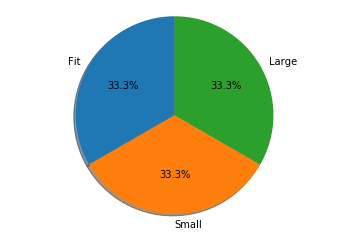

In [330]:
ytr = list(Y_train_resampled)
sizes = [len([x for x in ytr if x == 0]), len([x for x in ytr if x == -1]), len([x for x in ytr if x == 1])]
labels = ["Fit", "Small", "Large"]
import matplotlib.pyplot as plt
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')
plt.show()

In [331]:
Y_test_resampled.head()

38587    -1
112134   -1
113399    1
110292    1
128605    0
Name: fit, dtype: int64

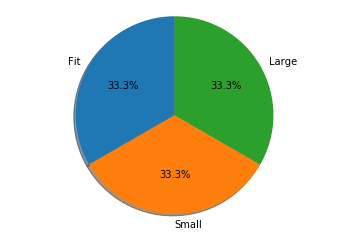

In [332]:
ytr = list(Y_test_resampled)
sizes = [len([x for x in ytr if x == 0]), len([x for x in ytr if x == -1]), len([x for x in ytr if x == 1])]
labels = ["Fit", "Small", "Large"]
import matplotlib.pyplot as plt
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')
plt.show()

### Classifier Models on Resampled Data:
- Random Forest (10 estimators)
- Random Forest (100 estimators)
- Gradient Boosting
- Neural Network: Multilayer Perceptron

In [333]:
# Create classifers
rf10 = RandomForestClassifier(n_estimators=10)
rf = RandomForestClassifier(n_estimators=100)
gb = GradientBoostingClassifier()
nn = MLPClassifier()

# Train Classifers
rf10 = rf10.fit(X_train_resampled, Y_train_resampled)
rf = rf.fit(X_train_resampled, Y_train_resampled)
gb = gb.fit(X_train_resampled, Y_train_resampled)
nn = nn.fit(X_train_resampled, Y_train_resampled)

#Predict the response for test dataset
rf10_y_pred = rf10.predict(X_test_resampled)
rf_y_pred = rf.predict(X_test_resampled)
gb_y_pred = gb.predict(X_test_resampled)
nn_y_pred = nn.predict(X_test_resampled)

print("Random Forest:")
print("10 estimators Training Accuracy:", metrics.accuracy_score(Y_train_resampled, rf10.predict(X_train_resampled)))
print("10 estimators Test Accuracy:",metrics.accuracy_score(Y_test_resampled, rf10_y_pred))
print("100 estimators Training Accuracy:", metrics.accuracy_score(Y_train_resampled, rf.predict(X_train_resampled)))
print("100 estimators Test Accuracy:",metrics.accuracy_score(Y_test_resampled, rf_y_pred))

print("\nGradient Boosting:")
print("Training Accuracy:", metrics.accuracy_score(Y_train_resampled, gb.predict(X_train_resampled)))
print("Test Accuracy:",metrics.accuracy_score(Y_test_resampled, gb_y_pred))

print("\nNeural Network:")
print("Training Accuracy:", metrics.accuracy_score(Y_train_resampled, nn.predict(X_train_resampled)))
print("Test Accuracy:",metrics.accuracy_score(Y_test_resampled, nn_y_pred))

Random Forest:
10 estimators Training Accuracy: 0.9972453990179249
10 estimators Test Accuracy: 0.5186021505376344
100 estimators Training Accuracy: 1.0
100 estimators Test Accuracy: 0.5417204301075269

Gradient Boosting:
Training Accuracy: 0.6100310058951123
Test Accuracy: 0.5964516129032258

Neural Network:
Training Accuracy: 0.4202163759032297
Test Accuracy: 0.41763440860215056


On the resample: Even thirds, 33% small, 33% fit, 33% large
Gradient Boosting here is 50% more accurate than random guessing

In [334]:
#Y_test_resampled.head()
a = pd.DataFrame(Y_test_resampled)
print(a.head())

print( (len(a[a['fit'] == 0])) / (len(a.index))  )

        fit
38587    -1
112134   -1
113399    1
110292    1
128605    0
0.3333333333333333


In [335]:
import numpy as np

# rfImportances = pd.DataFrame(rf.feature_importances_, index = X_train_resampled.columns, columns =['importance']).sort_values('importance', ascending=False)
gbImportances = pd.DataFrame(gb.feature_importances_, index = X_train_resampled.columns, columns =['importance']).sort_values('importance', ascending=False)
# rfImportances

In [336]:
gbImportances

,importance
item_id,0.457314
size,0.293360
weight,0.116064
category,0.065075
bust_volume,0.013727
age,0.011937
body_type,0.011801
rented_for,0.011772
bust_height,0.007505
height,0.006419
